In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [2]:
data_csv = "C:\\Users\\dvb07\\OneDrive\\classificator\\predconstr\\prep_phrases_db.csv"

df = pd.read_csv(data_csv)
df.head()

,phrase,host,prep,dependant,dependant_case,dependant_lemma,dependant_num,dependant_pos,host_lemma,host_pos,label,corpus
0,прицепились к весу багажа,прицепились,к,весу,datv,вес,sing,NOUN,прицепиться,VERB,тематив,taiga
1,к нему направился,направился,к,нему,datv,он,sing,NPRO,направиться,VERB,директив,taiga
2,к предстоящему отопительному сезону готовы,готовы,к,сезону,datv,сезон,sing,NOUN,готовый,ADJS,дестинатив,taiga
3,привлечения к уголовной ответственности,привлечения,к,ответственности,datv,ответственность,sing,NOUN,привлечение,NOUN,потенсив,taiga
4,принадлежащие ко дворцу службы,принадлежащие,к,дворцу,datv,дворец,sing,NOUN,принадлежащий,ADJF,квалификатив,taiga


In [3]:
df1 = df[
    (df.label == 'локатив') & (df.prep.isin(('в', 'на', 'по', 'за', 'у')))
    | ((df.label == 'темпоратив') & (df.prep.isin(('в', 'на', 'до', 'за', 'после'))))
    | ((df.label == 'тематив') & (df.prep.isin(('о', 'по', 'в', 'с', 'на'))))
    | ((df.label == 'объект') & (df.prep.isin(('о', 'с', 'за', 'на', 'между'))))
    | ((df.label == 'директив') & (df.prep.isin(('в', 'из', 'на', 'с', 'к'))))
    | ((df.label == 'дестинатив') & (df.prep.isin(('для', 'на', 'к', 'в', 'за'))))
    | ((df.label == 'квалификатив') & (df.prep.isin(('из', 'по', 'для', 'в', 'без')))) # was excluded
    | ((df.label == 'сурсив') & (df.prep.isin(('в', 'у', 'от', 'из', 'по мнению'))))
    | ((df.label == 'квантитатив') & (df.prep.isin(('из', 'на', 'в', 'до', 'около'))))
    | ((df.label == 'комитатив') & (df.prep.isin(('с', 'у', 'вместе с', 'при', 'за')))) # was excluded
]
len(df1)

8459

In [4]:
df2 = df[
    ((df.label == 'тематив') & (df.prep.isin(('о', 'по', 'в', 'с', 'на'))))
    | ((df.label == 'объект') & (df.prep.isin(('о', 'с', 'за', 'на', 'между'))))
]

In [5]:
df1.label.value_counts()

label
локатив         1932
тематив         1172
темпоратив      1113
объект           863
директив         739
дестинатив       707
сурсив           604
квалификатив     499
комитатив        422
квантитатив      408
Name: count, dtype: int64

In [6]:
df11 = df1.copy()
df11.label.replace({'объект': 'объект_тематив', 'тематив': 'объект_тематив'}, inplace=True)

In [7]:
df11.label.value_counts()

label
объект_тематив    2035
локатив           1932
темпоратив        1113
директив           739
дестинатив         707
сурсив             604
квалификатив       499
комитатив          422
квантитатив        408
Name: count, dtype: int64

In [8]:
# cointegrated/LaBSE-en-ru f1=0.77 here vs f1=0.69 on baseline
# DeepPavlov/rubert-base-cased
# ai-forever/sbert_large_nlu_ru

# DeepPavlov/rubert-base-cased-sentence
# ai-forever/ruRoberta-large

In [9]:
model = SentenceTransformer('ai-forever/ruRoberta-large')

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

No sentence-transformers model found with name C:\Users\dvb07/.cache\torch\sentence_transformers\ai-forever_ruRoberta-large. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\dvb07/.cache\torch\sentence_transformers\ai-forever_ruRoberta-large were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initiali

In [10]:
sentences = df11.phrase.values.tolist()
sentences2 = df2.phrase.values.tolist()
labels = df11.label.values.tolist()
labels2 = df2.label.values.tolist()
print(sentences[:2], labels[:2])
print(sentences2[:2], labels2[:2])

['к нему направился', 'к предстоящему отопительному сезону готовы'] ['директив', 'дестинатив']
['обсудила с главой США', 'отношения с ЕС'] ['объект', 'объект']


In [11]:
embeddings = model.encode(sentences,show_progress_bar=True)
embeddings2 = model.encode(sentences2,show_progress_bar=True)

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

In [13]:
columns=[f'embedding{i}' for i in range(1024)]
df_embeddings = pd.DataFrame(embeddings, columns=columns)
df_embeddings2 = pd.DataFrame(embeddings2, columns=columns)

In [14]:
X = df_embeddings.copy()
X2 = df_embeddings2.copy()

In [15]:
le = LabelEncoder()
le2 = LabelEncoder()
y = le.fit_transform(labels)
y2 = le2.fit_transform(labels2)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train2, X_test2, y_train2, y_test2 =  train_test_split(X2, y2, test_size=0.2, random_state=0, stratify=y2)

In [17]:
from sklearn.linear_model import LogisticRegression

0.7641843971631206
0.7152238698630008
0.7611872878730135
0.7641843971631206
0.7617752778324333


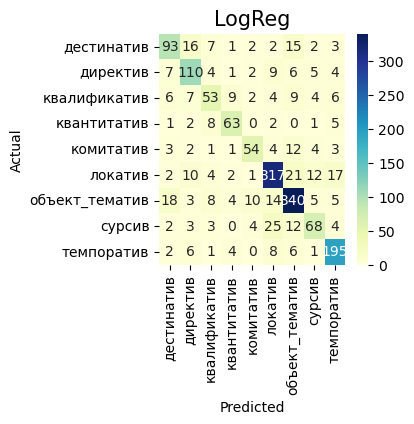

                precision    recall  f1-score   support

    дестинатив       0.69      0.66      0.68       141
      директив       0.69      0.74      0.72       148
  квалификатив       0.60      0.53      0.56       100
   квантитатив       0.74      0.77      0.75        82
     комитатив       0.72      0.64      0.68        84
       локатив       0.82      0.82      0.82       386
объект_тематив       0.81      0.84      0.82       407
        сурсив       0.67      0.56      0.61       121
    темпоратив       0.81      0.87      0.84       223

      accuracy                           0.76      1692
     macro avg       0.73      0.72      0.72      1692
  weighted avg       0.76      0.76      0.76      1692



In [18]:
classifier_general = LogisticRegression(random_state=0, max_iter=10_000, verbose=0, n_jobs=-1)
classifier_general.fit(X_train, y_train)
predicted = classifier_general.predict(X_test)
print(accuracy_score(y_test, predicted))
print(balanced_accuracy_score(y_test, predicted))
print(precision_score(y_test, predicted, average='weighted', zero_division=0))
print(recall_score(y_test, predicted, average='weighted', zero_division=0))
print(f1_score(y_test, predicted, average='weighted', zero_division=0))
cnfmat = confusion_matrix(y_test,predicted)
plt.subplots(figsize=(3,3))
sns.heatmap(cnfmat,annot=True,fmt="1d",cbar=True,xticklabels=le.classes_,yticklabels=le.classes_, cmap='YlGnBu')
plt.title('LogReg',fontsize=15)
plt.xlabel("Predicted",fontsize=10)
plt.ylabel("Actual",fontsize=10)
plt.show()
print(classification_report(y_test, predicted, target_names=le.classes_))

0.6093366093366094
0.6052566572797786
0.613554385850401
0.6093366093366094
0.6108289963443168


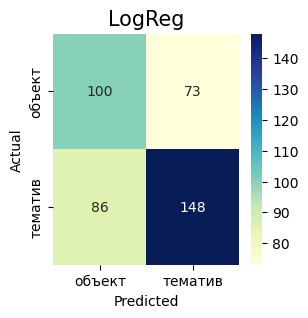

              precision    recall  f1-score   support

      объект       0.54      0.58      0.56       173
     тематив       0.67      0.63      0.65       234

    accuracy                           0.61       407
   macro avg       0.60      0.61      0.60       407
weighted avg       0.61      0.61      0.61       407



In [19]:
classifier_small = LogisticRegression(random_state=0, max_iter=10_000, verbose=0, n_jobs=-1)
classifier_small.fit(X_train2, y_train2)
predicted_small = classifier_small.predict(X_test2)
print(accuracy_score(y_test2, predicted_small))
print(balanced_accuracy_score(y_test2, predicted_small))
print(precision_score(y_test2, predicted_small, average='weighted', zero_division=0))
print(recall_score(y_test2, predicted_small, average='weighted', zero_division=0))
print(f1_score(y_test2, predicted_small, average='weighted', zero_division=0))
cnfmat = confusion_matrix(y_test2,predicted_small)
plt.subplots(figsize=(3,3))
sns.heatmap(cnfmat,annot=True,fmt="1d",cbar=True,xticklabels=le2.classes_,yticklabels=le2.classes_, cmap='YlGnBu')
plt.title('LogReg',fontsize=15)
plt.xlabel("Predicted",fontsize=10)
plt.ylabel("Actual",fontsize=10)
plt.show()
print(classification_report(y_test2, predicted_small, target_names=le2.classes_))

In [20]:
import warnings
warnings.simplefilter('ignore')

In [21]:
model_predictions = []
for x in X.values:
    pred = classifier_general.predict([x])[0]
    label = le.classes_[pred]
    if label == 'объект_тематив':
        pred = classifier_small.predict([x])[0]
        label = le2.classes_[pred]
    model_predictions.append(label)

In [22]:
le_final = LabelEncoder()
pred_labels = le_final.fit_transform(model_predictions)
true_labels = le_final.fit_transform(df1.label)

0.8952594869369902
0.8949870836056858
0.8955133923918174
0.8952594869369902
0.8952944317048083
              precision    recall  f1-score   support

  дестинатив       0.94      0.93      0.93       707
    директив       0.92      0.94      0.93       739
квалификатив       0.92      0.88      0.90       499
 квантитатив       0.94      0.95      0.95       408
   комитатив       0.95      0.93      0.94       422
     локатив       0.96      0.96      0.96      1932
      объект       0.72      0.71      0.72       863
      сурсив       0.93      0.90      0.92       604
     тематив       0.76      0.78      0.77      1172
  темпоратив       0.95      0.97      0.96      1113

    accuracy                           0.90      8459
   macro avg       0.90      0.89      0.90      8459
weighted avg       0.90      0.90      0.90      8459



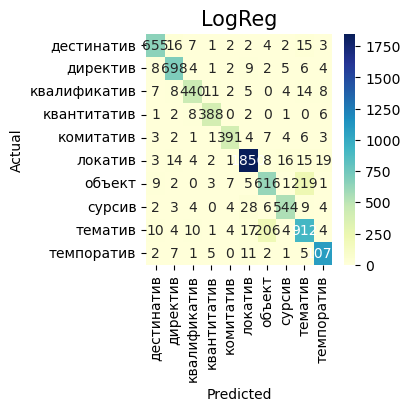

In [23]:
print(accuracy_score(true_labels, pred_labels))
print(balanced_accuracy_score(true_labels, pred_labels))
print(precision_score(true_labels, pred_labels, average='weighted', zero_division=0))
print(recall_score(true_labels, pred_labels, average='weighted', zero_division=0))
print(f1_score(true_labels, pred_labels, average='weighted', zero_division=0))
cnfmat = confusion_matrix(true_labels,pred_labels)
plt.subplots(figsize=(3,3))
sns.heatmap(cnfmat,annot=True,fmt="1d",cbar=True,xticklabels=le_final.classes_,yticklabels=le_final.classes_, cmap='YlGnBu')
print(classification_report(true_labels, pred_labels, target_names=le_final.classes_))
plt.title('LogReg',fontsize=15)
plt.xlabel("Predicted",fontsize=10)
plt.ylabel("Actual",fontsize=10)
plt.show()